In [1]:
from collections import defaultdict
from importlib import reload
from itertools import product
from pathlib import Path
from time import perf_counter

import sys
sys.path.append("../src")
import convex
import frank_wolfe
import main_gaussian
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm



[KeOps] Warning : There were warnings or errors compiling formula :
<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

[KeOps] Warning : 
    The location of Cuda header files cuda.h and nvrtc.h could not be detected on your system.
    You must determine their location and then define the environment variable CUDA_PATH,
    either before launching Python or using os.environ before importing keops. For example
    if these files are in /vol/cuda/10.2.89-cudnn7.6.4.38/include you can do :
      import os
      os.environ['CUDA_PATH'] = '/vol/cuda/10.2.89-cudnn7.6.4.38'
    
[KeOps] Compiling cuda jit compiler engine ... 
[KeOps] Warning : There were warnings or errors compiling formula :
/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keopscore/binders/nvrtc/nvrtc_jit.cpp:5:10: fatal error: nvrtc.h: No such file or directory
    5 | #include <nvrtc.h>
      |          ^~~~~~~~~
compilation terminated.

OK
[pyKeOps] Compiling nvrtc bin

In [9]:
def get_error(x_b, y_b, x_s, y_s, w, k=10):
    s = w.argsort()[::-1][:k]
    x_k = x_s[s]
    y_k = y_s[s]
    beta_k = np.linalg.pinv(x_k) @ y_k
    y_hat = x_b @ beta_k

    # LR = LinearRegression(fit_intercept=False)
    # LR.fit(x_k, y_k)
    # y_hat = LR.predict(x_b)
    return mean_squared_error(y_b, y_hat)

In [53]:
reload(utils)
data = utils.get_data(
    # dataset="gaussian",
    dataset="bone",
    num_buyer=30,
    num_seller=1000,
    dim=100,
    noise_level=0.1,
)

x_s = data["X_sell"].astype(np.single)
y_s = data["y_sell"]
x_val = data["X_val"].astype(np.single)
y_val = data["y_val"]
x_b = data["X_buy"].astype(np.single)
coef = data.get("coef")
y_b = (data["X_buy"] @ coef) if coef is not None else data["y_buy"]

In [60]:
rang = list(range(2, 30, 2)) + list(range(20, 150, 5))

errors = defaultdict(list)

for j in range(0, x_b.shape[0]):
    x_test = x_b[j : j + 1]
    y_test = y_b[j : j + 1]

    res_fw = main_gaussian.design_selection(
        (x_s, y_s),
        (x_test, y_test),
        num_select=10,
        num_iters=500,
        alpha=0.1,
        recompute_interval=0,
        line_search=True,
    )
    w_fw = res_fw["weights"]
    w_os = frank_wolfe.one_step(x_s, x_test)
    errors['Ours (multi-step)'].append([get_error(x_test, y_test, x_s, y_s, w_fw, k) for k in rang])
    errors['Ours (single step)'].append([get_error(x_test, y_test, x_s, y_s, w_os, k) for k in rang])


    w_baselines = main_gaussian.get_baseline_values(
        x_s, y_s, x_val, y_val, np.ones_like(x_val), np.ones_like(y_val), 
        baselines=[
            "DataOob",
            'KNNShapley',
            'LavaEvaluator',
            'RandomEvaluator',
            'DVRL',
            'InfluenceSubsample',
            'DataBanzhaf',
            'DataShapley',
            'LeaveOneOut',
            'BetaShapley',
        ],
        baseline_kwargs={
            'DataOob': {'num_models': 100},
            'KNNShapley': {},
            'LavaEvaluator': {},
            'DVRL': {'rl_epochs': 100},
            'InfluenceSubsample': {'samples': 100},
            'DataBanzhaf': {'num_models': 100, 'models_per_epoch': 10},
            'DataShapley': {'min_models': 100, 'models_per_epoch': 10},
            'BetaShapley': {'min_models': 100, 'models_per_epoch': 10},
            'LeaveOneOut': {},
        },
    )[]

    for k, v in w_baselines.items():
        errors[k].append([get_error(x_test, y_test, x_s, y_s, v, k) for k in rang])

    # w_cvx = V.optimize(x_test, x_s)
    # err_cvx.append([get_error(x_test, y_test, x_s, y_s, w_cvx, k) for k in rang])

    w_rand = np.random.permutation(len(x_s))
    errors['Random'].append([get_error(x_test, y_test, x_s, y_s, w_rand, k) for k in rang])
    print(f'round {j} done')
    break

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 99.31it/s]


----------------DataOob-----------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.40it/s]


	TIME: 7
---------------KNNShapley---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 6543.17it/s]


	TIME: 0
-------------LavaEvaluator--------------


	TIME: 0
------------RandomEvaluator-------------
	TIME: 0
------------------DVRL------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:40<00:00,  6.23it/s]


	TIME: 162
-----------InfluenceSubsample-----------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:40<00:00,  4.53it/s]


	TIME: 221
--------------DataBanzhaf---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:15<00:00,  5.10it/s]


	TIME: 196
--------------DataShapley---------------
Start: marginal contribution computation


  1%|█▍                                                                                                                                               | 1/100 [00:25<42:39, 25.86s/it]

KeyboardInterrupt: 

In [55]:
figure_dir = Path('../figures')

Text(0, 0.5, 'Prediction Error')

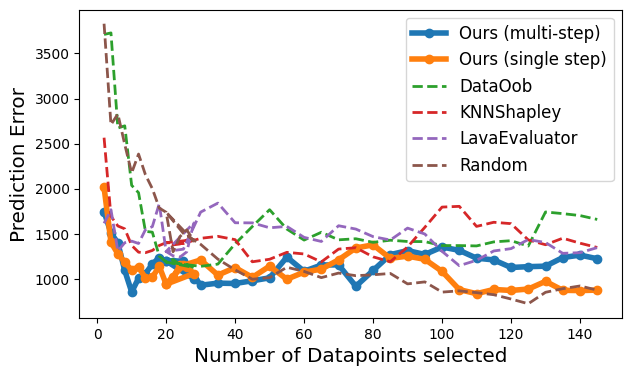

In [59]:
plt.figure(figsize=(7, 4))
for k, v in errors.items():
    err = np.array(v).mean(0).squeeze()
    marker = 'o' if 'Ours' in k else None
    ls = '-' if 'Ours' in k else '--'
    lw = 4 if 'Ours' in k else 2
    plt.plot(rang, err, label=k, marker=marker, ls=ls, lw=lw)
# plt.xlim(0, 100)
# plt.ylim(0, 2)
# plt.yticks(np.arange(0, 2.1, 0.5))
plt.legend(fontsize='large')
plt.xlabel('Number of Datapoints selected', fontsize='x-large')
plt.ylabel('Prediction Error', fontsize='x-large')
# plt.savefig(figure_dir / f"baseline-compare-bone.eps", bbox_inches="tight")

In [65]:
from sklearn.datasets import make_regression

In [267]:
x, y, b = make_regression(n_samples = 100, n_features=1, noise=40, coef=True, bias=True, tail_strength=1.5)

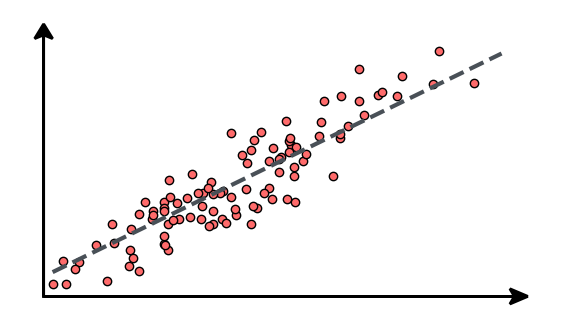

In [289]:
fig, ax = plt.subplots(figsize=(7, 4))
# your plotting code here, replace plt with ax for plot commands

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Optionally, you can also move the bottom and left spines
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_position(('outward', 10))

x_min = x.min() - 0.1
x_max = x.max() + 0.4
y_min = y.min() - 20
y_max = y.max() + 20

ax.scatter(x, y, c='#ff6b6b', edgecolor='k')
r = np.arange(x_min + 0.1, x_max)
ax.plot(r, r * b, c='#495057', lw=3, ls='--')
ax.arrow(x_min, y_min, 0., abs(y_min) + y_max, fc='k', ec='k', lw = 2, 
         head_width=0.2, head_length=6, overhang = 4, 
         length_includes_head= False, clip_on = True)
ax.arrow(x_min, y_min, abs(x_min) + x_max, 0, fc='k', ec='k', lw = 2, 
         head_width=25, head_length=0.05, overhang = 4, 
         length_includes_head= False, clip_on = True)

ax.set_xticklabels([])
ax.set_yticklabels([])


plt.savefig(figure_dir / f"regression.png", bbox_inches="tight", dpi=500)



In [301]:
import uuid
from datetime import datetime

# Current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d-%H%M%S")

# Generate a random UUID
random_uuid = uuid.uuid4()

# Concatenate timestamp and UUID
human_readable_uuid = f"{timestamp}-{random_uuid}"

print(human_readable_uuid)


2024-01-17-020458-13b455ae-7165-4392-b096-80f6506ddc9b


In [302]:
import pickle 

In [305]:
with open('../results/2024-01-17-021938-4dd5eef3-8817-4834-99d9-c491acd6dcf0-data.pkl', 'rb') as f:
    res = pickle.load(f)

In [ ]:
res['X_sell'].shape

In [314]:
import json
json.dumps(dict(errors))

'{"Ours (multi-step)": [[1676.876021594395, 6329.662210361595, 7824.343889231158, 4115.330114091098, 3381.0201896060794, 3585.822544142135, 5811.203588180038, 7582.32614953995, 7656.617115447818, 8342.968538685402, 6632.253516747381, 6992.841343892945, 6863.264905891647, 5417.228332613403, 8342.968538685402, 7072.770761552563, 5616.061796227386, 4802.092464194233, 7413.657578657398, 6131.426161279152, 4535.4336738105285, 4755.433653690588, 4695.758530168896, 5560.06479986683, 5750.093497940013, 3704.967913727332, 4322.797183784785, 2074.015869166348, 1462.9822383001099, 1698.5614271197462, 2389.0077239081097, 2404.3368557358012, 2614.723209963688, 3731.6606344292477, 3523.806310046411, 2350.1056426296736, 1986.798932071955, 1607.0930088162315, 1989.3873913082273, 1729.8508355130962]], "Ours (single step)": [[23.047437341406166, 730.8008358045057, 761.8226537179647, 864.454328656785, 5704.302879591556, 7746.571557813488, 4925.3347326166495, 4762.518240892113, 6516.692955739871, 6438.598